In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import unsupervised_helper

%aimport unsupervised_helper

vp = unsupervised_helper.VanderPlas()


**References**

- Triplet Loss: [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Sentence BERT: [entence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf))



# Embeddings

From our module on [Transfer Learning](Transfer_Learning.ipynb) and [CLIP](CLIP.ipynb)
- we understand that a Sequential Deep Learning model
- has multiple layers prior to the task-specific "head" (e.g., Classifier)
    - that create alternate representations of the Input
    - of increasing complexity as we go Deeper (closer to the Head)
   
The purpose of the layers from the Input to the Head
- is to create a representation
- from which the  Head can correctly solve the task (e.g., predict the label)

These alternate representations are called *embeddings* of the Input.

We also hypothesize that 
- embeddings that are close to the input
    - represent "syntax" concepts
 embeddings that are close to the Head
     - represent "semantic" concepts
     - but if we are too close to the Head
        - embeddings are over-specialized to the Source task used for training   


We wish to understand behavior of embeddings visually.

Given a number of inputs
- we can compute the embedding of each
- and plot them in embedding space
- in order to understand the structure of embedding space

Here is a plot of the embeddings
- of a subset of the 10 digits

Although embeddings are typically high dimension
- we plot in 2D space
    - define by the first 2 Principal Components
- as a practical matter

In [4]:
vpt = unsupervised_helper.VanderPlas()

subset1 = [ 0, 4, 7, 9 ]
rh_digits = unsupervised_helper.Reconstruct_Helper( subset=[])
rh_digits.create_data_digits(subset=subset1)

n_components = 8
_= rh_digits.fit(n_components=n_components)

# Get X tilde and the targets
Xtilde = rh_digits.dataProj
y = rh_digits.targets

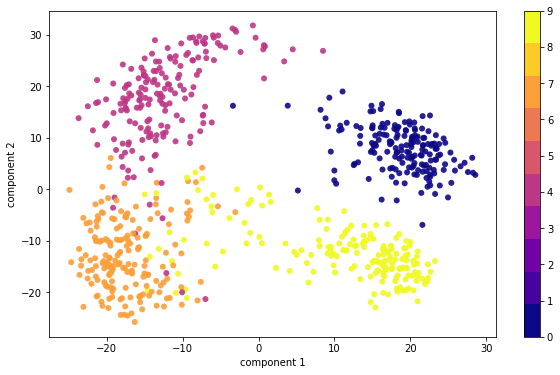

In [5]:
vpt.digits_subset_show_clustering(Xtilde, y, save_file="/tmp/digits_subset_cluster.jpg" )

And here is the clustering of text articles across different classes.


<table>
    <tr>
        <th><center>Text Embeddings</center></th>
    </tr>
    <tr>
        <td><img src="images/sbert_clustering.png" width-60%></td>
    </tr>
   
</table>
 <br>
    Attribution: https://joeddav.github.io/blog/2020/05/29/ZSL.html


It would seem
- that examples of the *same class* (e.g., digit or article topic)
- have embeddings that are close to one another
    - forming clusters in embedding space
    
This may explain why
- feeding embeddings into a Classifier head
- results in successful Classification



# Using Embeddings to solve a task without fine-tuning

The traditional way that we have used Embeddings is via Transfer Learning
- keep a prefix of layers of a model trained for a Source task
    - use the embeddings created by the prefix
- append a new Head for a Target task
- train the Head on a small number of examples of the Target task
    - possibly also fine-tuning the weights in the prefix

But, we could use the embeddings directly
- starting with a dataset of examples for a Target task
- create an equivalent dataset of embeddings
    - map each input to its embedding
    
In this approach
- we don't modify (or need access to the source code) the prefix layers
- just treat the Source model as producing embeddings

This is motivated by the possibility
- that a new Target task
- can be solved *without training*
- just by comparing embeddings

## Zero-shot classification

A simple approach to Classification via embeddings is like K-nearest neighbors (KNN)
- map an input $\x$ to its embedding $\text{embed}(\x)$
- predict $\hat\y$, the label of $\x$
    - as the label $\y^\ip$ of an example $\langle \x^\ip, \y^\ip \rangle$
    - in a pre-defined set of labeled exampled $$[ \langle \x^\ip, \y^\ip \rangle \; | \; 1 \le i \le m ]$$
    - whose embedding $\text{embed}(\x^\ip)$
    - is *closest* to $\text{embed}(\x)$
    
    $$
    \text{embed}(\x) \approx \text{embed}(\x^\ip)
    $$
- so predict $\hat\y = \y^\ip$

Note that this approach
- does not involve computing/adapting parameters of any model
- zero-shot

A simple example: facial (or image) recognition
- compare the embedding of an image
- with the embeddings of the fixed number of images for each class (e.g., person)

## Semantic search

Want to create your own search engine ?
- create text embeddings  for each document in a collection
- create an embedding of your query

The document whose embedding is closest to the query's embedding would hopefully be the correct result.

**Note**

This is the basis for *Vector Stores*
- augmenting a LLM with your own data (e.g., GPT)

# Creating embeddings for similarity

Using the similarity of embeddings to solve a new Target task
- assumes that
- the embedding or "related" inputs
- are close to one another

We may get lucky and this will be the case for many tasks.

But we may need to train our embeddings
- with this as the specific goal
- by adding this as an objective of the Loss function

One such objective is the [Triplet Loss](https://arxiv.org/pdf/1503.03832.pdf)

Consider an input $a$ (the "anchor")
- with related input $p$ ("positive")
- with unrelated input $n$ ("negative")

Let 
- $s_a, s_p, s_n$ be the embedding produced by some layer, given input $a, p, n$
- $|| s - s' ||$ be a measure of the distance (inverse of similarity, always non-negative) between two embeddings $s, s'$

The Triplet Loss objective is to *minimize*
$$
\max{}( || s_a - s_p || - || s_a - s_n || + \epsilon, 0)
$$

The loss is minimized when
- $s_a$ is close to $s_p$
- $s_a$ is far from $s_n$

That is the embedding for anchor
- $a$ is very similar to that for $p$
- $a$ is very dissimilar to that for $n$

$\epsilon$ is called the *margin*
- the anchor must be closer to the positive example than the negative example
- by at least distance $\epsilon$

as can be seem by a little algebra:
$$
\begin{array} \\
\text{If } & ( || s_a - s_p || - || s_a - s_n || + \epsilon) < 0 \\
\text{re-arranging} & || s_a - s_p || < || s_a - s_n || - \epsilon \\
\end{array}
$$
so $|| s_a - s_n ||$ must be at least $\epsilon$ greater than $|| s_a - s_p ||$.

The purpose of the margin
- reduces the need for the optimizer to make $a$ and $p$ *exactly* coincide 
    - i.e., $|| s_a - s_p || = 0$

Training a Source task with the Triplet Loss
- produces embeddings
- that are useful for tasks that compare similarity of embeddings

# Example: Sentence Embeddings

To illustrate, we show [Sentence BERT](https://arxiv.org/pdf/1908.10084.pdf)
- fine-tunes the embeddings produced by BERT
- in order to make related sentences close in embedding space



Sentence-BERT builds a network based on the embeddings produced by BERT.

BERT is an Encoder style transformer.

A Transformer Encoder creates a Context Sensitive embedding of each input position.

By reducing the sequence (over positions) embeddings to a single embedding
- we can obtain a fixed length encoding of a variable length sequence of tokens

**Aside**

Historically, there are some common ways to perform the reduction of a sequence to a single value
- pooling (average over the embeddings)
- using a beginning/end "special" token (e.g., $\langle \text{CLS} \rangle$ to capture the summary of the entire sequence



Here is the architecture

<table>
    <tr>
        <th><center>Sentence BERT</th>
    </tr>
    <tr>
        <td><img src=images/sentence_bert_diag.png></td>
    </tr>
   
</table>
 <br>
    Attribution: https://arxiv.org/pdf/1908.10084.pdf#page=3

The pre-trained BERT model is *shared* across two inputs: Sentence A and Sentence B
- "weights are tied"
- BERT's weights are fine-tuned via the Triplet Loss objective

The sequence output of BERT is reduce by pooling (in this case)
- Sentence A is embedded as $u$
- Sentence B is embedded as $v$

In the diagram on the right, the Triplet Objective
- is recast as maximizing similarity (cosine distance)
- rather than minimizing distance 


**Aside**

The diagram on the left is for producing embeddings for a specific task
- entailment
    - Does Sentence B logically follow from Sentence A
- and hence is expressed as a Classification objective over labels $\{ \text{"Entail", "Does not entail"} \}$

The inputs to the classifier are the concatenation of
- the embedding $u$ of Sentence A
- the embedding $v$ of Sentence B
- the difference in the embeddings

(Presumably these three inputs facilitate Classsification)

The model is trained via batches that contain a mixture of
- Positive examples: Sentence A and Sentence B *are related* (anchor $a$ and positive $p$)
- Negative examples: Sentence A and Sentence B *are un-related* (anchor $a$ and positive $n$)

Triplet loss is minimized (or Utility maximized) in each batch.

## Performance

[Here](https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md#performance-comparison) is a comparison of Sentence BERT to other methods

The Sentence Embedding (Universal Sentence Encoder) scores highest
- outperforms Word Embeddings (the two GloVe entries)
- it *greatly outperforms* the simple reduction methods used on plain BERT output
    - pooling (BERT as a service avg embeddings)
    - special `<CLS>` token (BERT as a service CLS vector)

**Note**

The "sophisticated" BERT, when using simple reduction methods
- underperforms the "old school" word embeddings !


In [6]:
print("Done")

Done
